# Background
In the 4 years that City Year Los Angeles (CYLA) has utilized the HMH Math Inventory (MI) and Reading Inventory (RI), it has consistantly been observed that about a third of assessed students will decline from the first to the second assessment. Over the years there has been considerable conversation on what might be the cause of this decline for a seemingly large proportion of served students, and many hypotheses have been proposed related to ACM investment in assessments, student motivation, and variations in environmental conditions and student conditions.  However a lack of evidence for any hypothesis has typically stalled conversations on what the cause of the decline might be, and the site in many ways has shifted more to an acceptance that this will happen. 

However, recent reviews of research conducted by HMH on the MI and RI have begun to offer some clarity on the sources of measurement error for the MI and RI.  This information in turn has enabled us to begin to model what our expectations for 

In this paper we will start by seeking to understand Scholastic's research on the measurement error inherent in both assessments.  We will then consider the implications for a single student and quantify the likelihood that we observe a decline for that student. Finally, we model CYLA's program overall and quantify what our expectations for student decline should be, given the students we have. 

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Measurement Error in the MI/RI
Fundumantal to the problem is that intangible concepts like "reading comprehension" or "mathematical understanding" are hard to measure.  While ideally we would measure reading comprehension like we would a student's height, it's of course much more complicated then that requiring that we find indirect methods to represent an approximation of a student's reading comprehension. In the RI we measure a students' responses to questions about a passage of text, and this measurement is further complicated by the interaction of human behavior on top of it all. 

These sources of error cumulate in a measure called the SEM or standard errors of measurement. If a students has a "true" lexile of 700L, then the SEM describes the range in which the RI might measure that students Lexile.  For example, if the SEM were equal to 50 for a student with a lexile of 700L, then we would expect to measure the students Lexile between 650L and 750L two-thirds of the time.  Figure 1 shows the shape of this distribtuion below. 

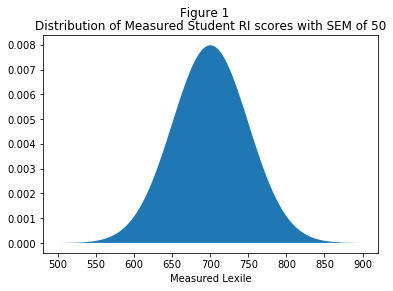

In [2]:
x_axis = np.arange(500, 900, 0.001)
fig = plt.figure(figsize=(6, 4))
fig.suptitle("Figure 1")
ax = fig.add_subplot(111)
ax.fill(x_axis, norm.pdf(x_axis, 700, 50))
ax.set_title("Distribution of Measured Student RI scores with SEM of 50")
ax.set_xlabel("Measured Lexile")
plt.show()

## Standard Errors in Measurement for MI/RI
In a report published by HMH titled *Accuracy Matters: Reducing Measurement Error by Targeted HMH Reading Inventory Testing*, the SEM for the RI is thoroughly explored. The most important factor in reducing the measurement error is the number of questions a student has answered.  Before a student has answered 40 questions, the assessment targets it's questions primarily by the grade level that student is in.  However, after answering 40 questions the assessment adjusts and includes the students' reading level in assessing a their Lexile. The SEM for first, second, and third round assessments in the RI are:

|Round|SEM w/o Established Reading Level|SEM w/ Established Reading level|
|:---:|:---:|:---:|
|1|91L|56L|
|2|73L|54L|
|3|56L|52L|

For the MI HMH has done less in detailing how the SEM will decrease as the system collects more information on a particular students.  In their Technical Guide HMH identified the SEM for MI as being 70Q and in a more recent guide on interrpring student declines adjusted the estimate down to 63Q. However, again that SEM is predicated on the student having an established baseline within the system, and thus prior to taking two administrations we should expect the SEM to be higher.  While we don't have precise numbers, it will be usefull to make esimtates of these values in a table like we have for the RI.  Because of the considerable uncertainty we have, I will provide ranges for each of the values as well.

|Round|SEM w/o Established Math Level|SEM w/ Established Math level|
|:---:|:---:|:---:|
|1|100Q +/- 5|63Q +/- 3|
|2|85Q +/- 5|61Q +/- 3|
|3|63Q +/- 3|59Q +/- 3|

While for either assessment the SEM will vary from student to student, we will use the values from above in conducting the modeling as they function as a reasonable approximation for setting our expectations in response to measurement error. 

## Decline for a Single Student
After we developed some understanding on the sources of variation in our Lexile and Quantile measurements we were prepared to analyze the consequences of those findings.  By utilizing the SEM measurement provided by HMH, we can use probability theory and Monte Carlo simulation methods to model the consequences both for a single student and for CYLA's program overall. 

Having determined Lexile and Quantile measurements are samples from a distribution, there are some consequences when those distributions overlap. To be concrete we'll visualize this situation for a student taking the MI.  Say that we know that a students' true ability at the baseline is 700Q.  In figure 2 we show the distributions for the baseline and follow up measurements given four different situations where their true math ability in the follow up is 700, 750, 800, and 850.  Key to understanding figure 2 is seeing the correlation between the probability of measuring a decline and the overlap between the two distribution.  When the two distributions are perfectly overlaid, then the probability of a measured decline is just a flip of a coin, 50%.  However, as a student improves more then the distributions from the baseline to the follow up get farther apart.  As a result the overlapping area gets smaller and the probability of measured decline correspondingly declines. 

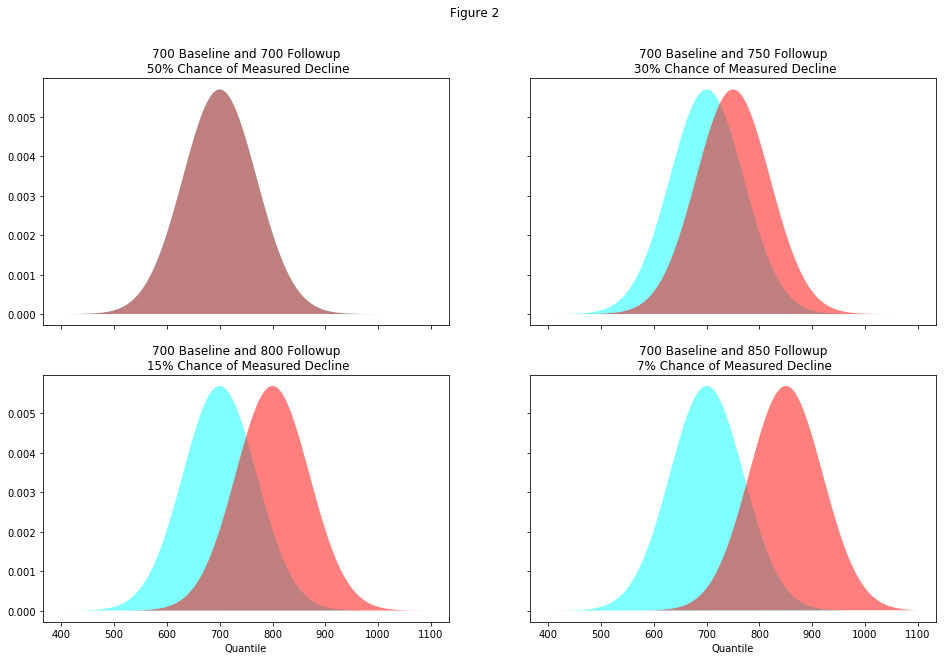

In [3]:
x_axis = np.arange(400, 1100, 1)

fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)
fig.suptitle("Figure 2")
axs[0,0].fill(x_axis, norm.pdf(x_axis, 700, 70), 'cyan', x_axis, norm.pdf(x_axis, 700, 70), 'red', alpha=0.5)
axs[0,0].set_title("700 Baseline and 700 Followup\n 50% Chance of Measured Decline")

axs[0,1].fill(x_axis, norm.pdf(x_axis, 700, 70), 'cyan', x_axis, norm.pdf(x_axis, 750, 70), 'red', alpha=0.5)
axs[0,1].set_title("700 Baseline and 750 Followup\n 30% Chance of Measured Decline")

axs[1,0].fill(x_axis, norm.pdf(x_axis, 700, 70), 'cyan', x_axis, norm.pdf(x_axis, 800, 70), 'red', alpha=0.5)
axs[1,0].set_title("700 Baseline and 800 Followup\n 15% Chance of Measured Decline")
axs[1,0].set_xlabel("Quantile")

axs[1,1].fill(x_axis, norm.pdf(x_axis, 700, 70), 'cyan', x_axis, norm.pdf(x_axis, 850, 70), 'red', alpha=0.5)
axs[1,1].set_title("700 Baseline and 850 Followup\n 7% Chance of Measured Decline")
axs[1,1].set_xlabel("Quantile")

plt.show()

In [117]:
def decline_likelihood(true_improvement):
    # Hidden Values
    true_baseline = 700
    true_followup = true_baseline + true_improvement
    
    # Model
    with pm.Model() as mi_model:
        baseline = pm.Normal('baseline', true_baseline, sd=91)
        followup = pm.Normal('followup', true_followup, sd=73)
        improvement = pm.Deterministic('improvement', followup - baseline)

        trace = pm.sample(10000, step=pm.Metropolis(), progressbar=False)

    return (trace['improvement'] < 0).mean()

improvements = [imp for imp in range(150)]
decline_likes = [decline_likelihood(imp) for imp in range(150)]

## Main Factors in the Probability of Decline
As we have seen, there are two main factors in determining the probability that a student will have a measured decline from baseline to follow up. 

1.  **Measurement Error** - As Scholastic pointed out, the SEM declines as a student gets assessed more.  It also drops significantly after a student has been assessed twice in the system. As the SEM declines probability of measured decline will also decrease.
2.  **Amount of True Improvement** - The probability of a measured decline declines as the amount of true improvement increases.

To give a sense of point 2, we performed a series of simulations to calculate the probability of measured decline for improvements ranging from 0 points to 150 and visualized it in figure 3.  The key takeaway is to notice that when improvement is close to 0, the probability that we measure a decline is close to 50%.  Then, as the amount of improvement increases, it becomes less and less likely that we measure a decline.  However, even when the true improvement is 100 points, there is still a ~18% probability of measuring a decline

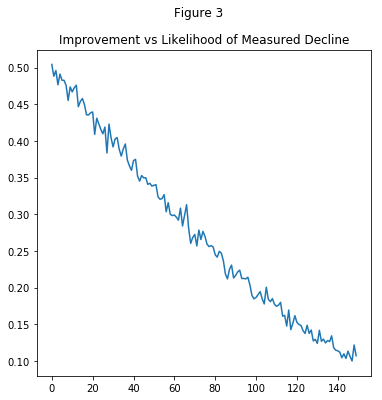

In [221]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle("Figure 3")
axs.plot(improvements, decline_likes)
axs.set_title("Improvement vs Likelihood of Measured Decline")
plt.show()

# Predicting the Amount of Measured Decline
So far we've constrained our examination to a single student, however we of course assess students with a variety of baseline scores and levels of improvement.  One thing that we have recognized is that grade level is one of the key factors in improvement on the MI and RI as well, so in analyzing CYLA's program we will focus on a single grade level before trying to model all grades. Our analysis pattern will be to first create a theoretical model for how MI and RI measurement work.  We will then expose the model to data from FY17 and use software to update our model based on the data.  With the pattern we will consider both MI and RI for the improvement from first to second and then first to third administrations. 

## Our Data
The data set we wil draw from is from the custom group for FY17.  Overall there are 3,236 students in the dataset, however filtering down to just 6th graders we can see that we have 408 students overall.  These students will serve for the initial analysis with the intention of developing an awareness of what to expect.

In [4]:
data = pd.read_csv('assessment_data.csv')
ri_first_followup = data[data.Grade == 6].dropna(axis=0, subset=['RI Imp 1 to 2'])
ri_second_followup = data[data.Grade == 6].dropna(axis=0, subset=['RI Imp 1 to 3'])
mi_first_followup = data[data.Grade == 6].dropna(axis=0, subset=['MI Imp 1 to 2'])
mi_second_followup = data[data.Grade == 6].dropna(axis=0, subset=['MI Imp 1 to 3'])
data[data.Grade == 6].describe()

,Grade,MI Baseline,MI Follow Up 1,MI Follow Up 2,RI Baseline,RI Follow Up 1,RI Follow Up 2,MI Imp 1 to 2,MI Imp 1 to 3,RI Imp 1 to 2,RI Imp 1 to 3
count,394.0,195.000000,177.000000,174.000000,280.000000,186.000000,200.000000,177.000000,174.000000,186.000000,200.000000
mean,6.0,415.820513,465.508475,532.729885,523.514286,539.908602,614.635000,51.073446,114.482759,31.666667,93.355000
std,0.0,182.759048,189.736723,218.929718,230.816301,219.004893,235.537921,164.632788,212.747013,130.826341,190.628606
min,6.0,-55.000000,25.000000,-215.000000,0.000000,0.000000,0.000000,-495.000000,-325.000000,-366.000000,-434.000000
25%,6.0,282.500000,325.000000,370.000000,352.000000,390.750000,457.000000,-80.000000,-23.750000,-32.500000,-19.750000
50%,6.0,410.000000,450.000000,547.500000,540.500000,542.500000,640.000000,50.000000,107.500000,21.500000,86.000000
75%,6.0,542.500000,600.000000,685.000000,711.000000,707.750000,798.500000,175.000000,223.750000,87.250000,199.500000
max,6.0,815.000000,910.000000,1065.000000,1044.000000,1008.000000,1123.000000,395.000000,765.000000,892.000000,769.000000


In [5]:
with pm.Model() as ri_first_followup_model:
    true_baseline = pm.Normal('baseline_mean', ri_first_followup['RI Baseline'].mean(), sd=ri_first_followup['RI Baseline'].std())
    true_improvement = pm.Normal('true_improvement', mu=30, sd=50)
    
    baseline = pm.Normal('baseline', true_baseline, sd=91, observed=ri_first_followup['RI Baseline']) # Using SD for students w/o existing baseline.  This is the most common class, so we'll get a better approximation with this than with the lower value.
    followup = pm.Normal('followup', baseline + true_improvement, sd=73, observed=ri_first_followup['RI Follow Up 1'])

    ri_first_followup_trace = pm.sample(10000)
    ri_first_followup_post = pm.sample_ppc(ri_first_followup_trace, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 3057.80it/s]


## Modeling the RI for the First to Second Administration
One of the benefits of modeling RI in the way that we are, is that we get access to another way to measure student improvement. Our model actually measures improvement on the RI in two different ways.  First is a variable for measured improvement.  This variable is equivalent to what we measure in our students after they have taken two assessments without any attempt to correct for the measurement error.  However we also add a variable which models the true amount that a student improves. While these values are unobserved, our model is able to reason about values that they might be given our understanding of the system. 

We observe both of these distributions in figure 4 below.  The left distribution, corresponding to measured improvement, is quite wide ranging from the negative 150's to the postive 200's. However when we control for measurement error the underlying distribution representing the true improvement is considerably tighter.  Instead of a 350 point range, it shrinks down to values in $32 \pm 10$.

In thinking about the likelihood of student decline, we can observe in figure 4 that a considerable chunk of our students are to the left of 0 for measured improvement.  Some quick math shows that it correponds to ~35% of students tested.  Important to note is that these simulations show that students will show as much as 100-150 points of decline, while still having a true improvement that is greater than 0.  We find in the data that actual RI decline from the first to the second administration was in 38% of students, which suggests that the vast amount of this decline can be explained by measurement error.  

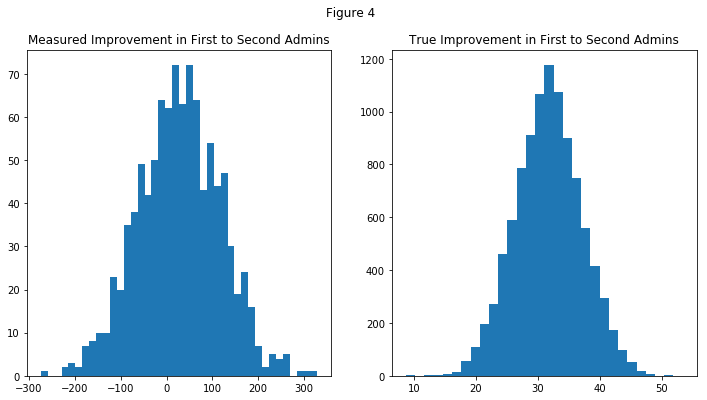

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Figure 4")
axs[0].hist((np.mean(ri_first_followup_post['followup'], axis=1) - ri_first_followup_post['baseline']), bins=40)
axs[0].set_title("Measured Improvement in First to Second Admins")

axs[1].hist(ri_first_followup_trace['true_improvement'], bins=30)
axs[1].set_title("True Improvement in First to Second Admins")
plt.show()

In [8]:
(ri_first_followup['RI Imp 1 to 2'] < 0).mean()

0.37634408602150538

In [9]:
# Probability of measured decline
((np.mean(ri_first_followup_post['followup'], axis=1) - ri_first_followup_post['baseline']) < 0).mean()

0.376

In [24]:
with pm.Model() as ri_second_followup_model:
    true_baseline = pm.Normal('baseline_mean', ri_second_followup['RI Baseline'].mean(), sd=ri_second_followup['RI Baseline'].std())
    true_improvement = pm.Normal('true_improvement', mu=90, sd=50)
    
    baseline = pm.Normal('baseline', true_baseline, sd=91, observed=ri_second_followup['RI Baseline']) # Using SD for students w/o existing baseline.  This is the most common class, so we'll get a better approximation with this than with the lower value.
    followup = pm.Normal('followup', baseline + true_improvement, sd=56, observed=ri_second_followup['RI Follow Up 2'])

    ri_second_followup_trace = pm.sample(10000)
    ri_second_followup_post = pm.sample_ppc(ri_second_followup_trace, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 3059.33it/s]


## Extending to the First to Third Administration
Our approach for the first to third administration data follows the same pattern as for the first to second administration.  The true improvement that we measured was $90 \pm 8$.  We also observed a decline in the percent of student whose measured lexiles decreased, from 35% of students down to 16%.  In our actual we find a bit of a inconsistancy in that about 30% of students in our dataset still declined.  

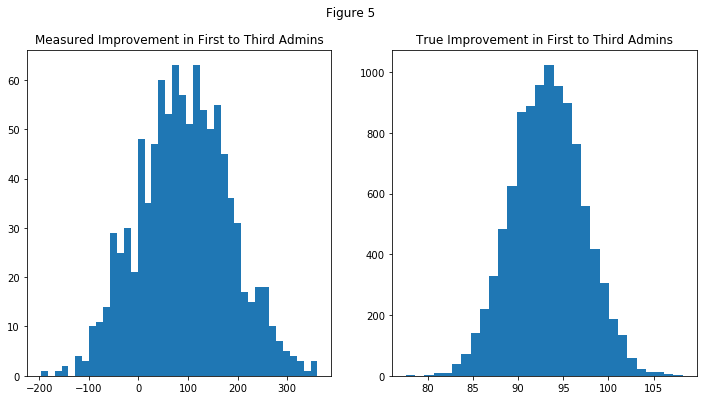

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Figure 5")
axs[0].hist((np.mean(ri_second_followup_post['followup'], axis=1) - ri_second_followup_post['baseline']), bins=40)
axs[0].set_title("Measured Improvement in First to Third Admins")

axs[1].hist(ri_second_followup_trace['true_improvement'], bins=30)
axs[1].set_title("True Improvement in First to Third Admins")
plt.show()

In [26]:
(ri_second_followup['RI Imp 1 to 3'] < 0).mean()

0.28999999999999998

In [27]:
# Probability of measured decline
((np.mean(ri_second_followup_post['followup'], axis=1) - ri_second_followup_post['baseline']) < 0).mean()

0.157

In [14]:
with pm.Model() as mi_first_followup_model:
    true_baseline = pm.Normal('baseline_mean', mi_first_followup['MI Baseline'].mean(), sd=mi_first_followup['MI Baseline'].std())
    true_improvement = pm.Normal('true_improvement', mu=50, sd=50)
    
    baseline = pm.Normal('baseline', true_baseline, sd=100, observed=mi_first_followup['MI Baseline']) # Using SD for students w/o existing baseline.  This is the most common class, so we'll get a better approximation with this than with the lower value.
    followup = pm.Normal('followup', baseline + true_improvement, sd=85, observed=mi_first_followup['MI Follow Up 1'])

    mi_first_followup_trace = pm.sample(10000)
    mi_first_followup_post = pm.sample_ppc(mi_first_followup_trace, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 3039.21it/s]


## Modeling the MI from the First to Second Administration
We apply the same pattern from RI to MI.  We find where our model predicted 31% decline in our students, we actually observed closer to 40%. The true improvement for students from first to second administration was measured to be $50 \pm 12$. 

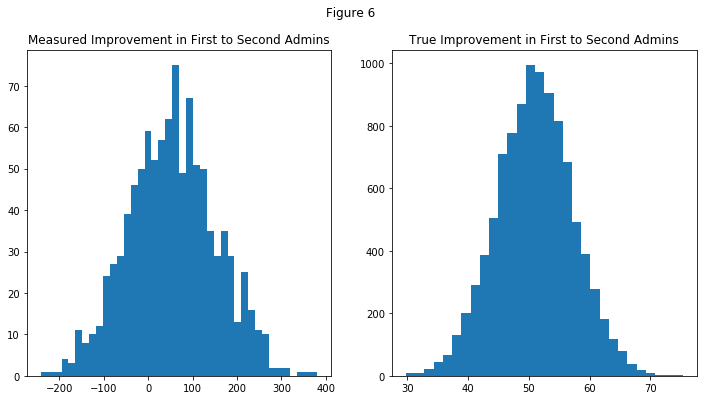

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Figure 6")
axs[0].hist((np.mean(mi_first_followup_post['followup'], axis=1) - mi_first_followup_post['baseline']), bins=40)
axs[0].set_title("Measured Improvement in First to Second Admins")

axs[1].hist(mi_first_followup_trace['true_improvement'], bins=30)
axs[1].set_title("True Improvement in First to Second Admins")
plt.show()

In [32]:
(mi_first_followup['MI Imp 1 to 2'] < 0).mean()

0.39548022598870058

In [33]:
# Probability of measured decline
((np.mean(mi_first_followup_post['followup'], axis=1) - mi_first_followup_post['baseline']) < 0).mean()

0.29399999999999998

In [28]:
with pm.Model() as mi_second_followup_model:
    true_baseline = pm.Normal('baseline_mean', mi_second_followup['MI Baseline'].mean(), sd=mi_second_followup['MI Baseline'].std())
    true_improvement = pm.Normal('true_improvement', mu=115, sd=50)
    
    baseline = pm.Normal('baseline', true_baseline, sd=91, observed=mi_second_followup['MI Baseline']) # Using SD for students w/o existing baseline.  This is the most common class, so we'll get a better approximation with this than with the lower value.
    followup = pm.Normal('followup', baseline + true_improvement, sd=73, observed=mi_second_followup['MI Follow Up 2'])

    mi_second_followup_trace = pm.sample(10000)
    mi_second_followup_post = pm.sample_ppc(mi_first_followup_trace, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 3059.33it/s]


## Extending to the First to Third Administration
In this case our model predicted that 26% of students would decline, which matched very closely to the 28% observed.  We also measured the true improvement to be $115 \pm 11$.

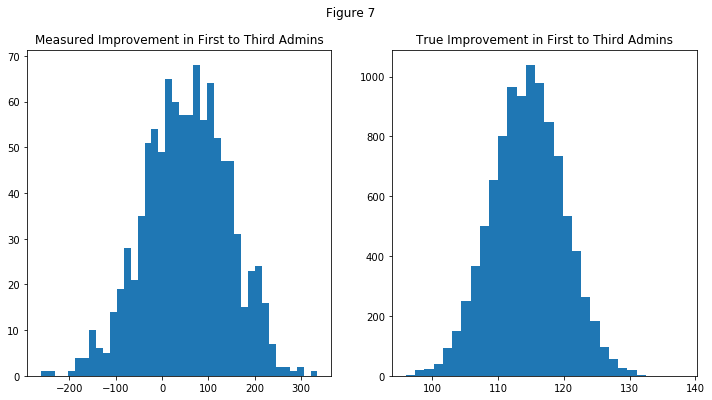

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Figure 7")
axs[0].hist((np.mean(mi_second_followup_post['followup'], axis=1) - mi_second_followup_post['baseline']), bins=40)
axs[0].set_title("Measured Improvement in First to Third Admins")

axs[1].hist(mi_second_followup_trace['true_improvement'], bins=30)
axs[1].set_title("True Improvement in First to Third Admins")
plt.show()

In [30]:
(mi_second_followup['MI Imp 1 to 3'] < 0).mean()

0.28160919540229884

In [31]:
# Probability of measured decline
((np.mean(mi_second_followup_post['followup'], axis=1) - mi_second_followup_post['baseline']) < 0).mean()

0.27300000000000002

# Conclusion
## Key Findings
There were two key findings in this paper. 

1. Student decline can indeed result from the measurement error inherent in the assessments.  Measurement error explains most of the decline observed in our students. 
2. We can controll for measurement error and produce and estimate of the true improvement a student experienced.

### Discussion on the Model 
The model we have used to analyze each case is asofyet incomplete.  In addition to only modeling 6th grade students, in each case the model failed to both predict the extreme values that we see in measured improvement as well as consistantly underestimating the number of students who would decline from baseline to follow up assessment. In future analysis we will try to expand the scope of the model to take into account all grades we work with.  Follow up should also be done on students producing extreme improvement scores (either less than -200 or greater than 300).  These cases don't fall into our model, and yet are observed.  It is likely that in these cases there are some externalities that influenced these cases that aren't accounted for by the model.

### Retests
Perhaps the most notable reprocussion of this analysis in policy terms is for retests.  The current policy allows for retesting a student who declines by 100 points or more.  However, this analysis indicates that a drop of that amount is actually relatively common occuring in 18% of cases. Instead a more extreme limit should perhaps be put in place to catch the least common and most extreme cases.  One such cutoff might be a decrease of 200 points.  The goal of raising this cutoff would be to try to capture only those instances where the following factors had some influence on the score (per the recommendations in Interpreting Assessment Results from HMH):

* motivation
* inattention
* cheating
* misadministration
* poor testing conditions

# References

HMH. (2016) *Accuracy Matters: Reducing Measurement Error by Targeted HMH Reading Inventory Testing.*

HMH. (2014) *Math Inventory Technical Guide.*

HMH. (2016) *Interpreting Assessment Results.*

Scholastic. (2007) *Scholastic Reading Inventory Technical Guide.* Scholastic Inc.